In [1]:
import numpy as np
% load_ext autoreload
% reload_ext autoreload
% autoreload 2

In [2]:
from DShap import DShap
from shap_utils import *
import pandas as pd
import math
% matplotlib inline
MEM_DIR = './'

# Approach to messing up dataset

Goal: make the clean stroke dataset dirty.

1. Add noise to numerical features
2. Duplicate datapoints
3. Add wrong/dummy values to categorical features
4. Make some feature values null

# 1. Load and Mess Up Dataset
- [Stroke Dataset](https://www.kaggle.com/datasets/zzettrkalpakbal/full-filled-brain-stroke-dataset) (`brain_stroke.csv`) => binary classification: 4982 datapoints. Will make it dirty later.

In [3]:
df_stroke = pd.read_csv('datasets/brain_stroke.csv')
print("df_stroke shape = " + str(df_stroke.shape))
display(df_stroke)

df_stroke shape = (4981, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


## 1.1 Add noise to numerical features

<AxesSubplot: >

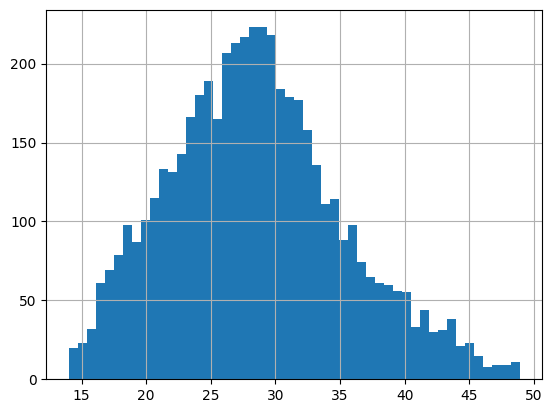

In [4]:
% matplotlib inline
df_stroke.bmi.hist(bins=50)

<AxesSubplot: >

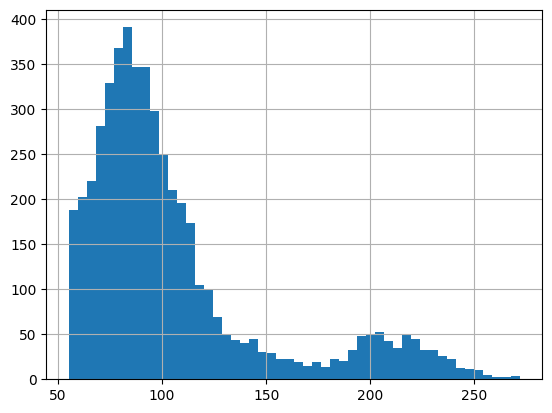

In [5]:
% matplotlib inline
df_stroke.avg_glucose_level.hist(bins=50)

Let us now add white noise to the `bmi` and `avg_glucose_level` numerical features.

In [6]:
df_stroke.bmi += np.random.normal(0, 5, size=df_stroke.shape[0])
df_stroke.avg_glucose_level += np.random.normal(0, 30, size=df_stroke.shape[0])
display(df_stroke)
print('df_stroke shape = {obj}'.format(obj=df_stroke.shape))

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,240.675932,40.655857,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,128.220296,38.827872,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,155.837980,29.175750,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,176.121823,22.770323,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,161.390164,32.308781,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,106.542343,25.701191,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,187.715921,18.646265,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,76.305755,31.742557,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,99.034837,33.634419,smokes,0


df_stroke shape = (4981, 11)


## 1.2 Add wrong/dummy values to categorical features

Define dummy categorical values.

In [7]:
residence_type_extra = ['in city']
gender_extra = ['unknown']

Alter 400 datapoints with dummy categorical values.

In [8]:
df_stroke.loc[
    df_stroke[df_stroke.work_type == 'Private'].sample(n=50, random_state=802).index, 'work_type'] = np.random.choice(
    ['Private Job', 'privatejob', 'corporate'], size=50)
df_stroke.loc[
    df_stroke[df_stroke.work_type == 'Govt_job'].sample(n=50, random_state=802).index, 'work_type'] = np.random.choice(
    ['Gov_job', 'Government'], size=50)
df_stroke.loc[df_stroke[df_stroke.work_type == 'Self-employed'].sample(n=50,
                                                                       random_state=802).index, 'work_type'] = np.random.choice(
    ['entrepreneur', 'Entrepreneur'], size=50)
df_stroke.loc[df_stroke[df_stroke.work_type == 'Self-employed'].sample(n=50,
                                                                       random_state=802).index, 'work_type'] = np.random.choice(
    ['entrepreneur', 'Entrepreneur'], size=50)
np.unique(df_stroke['work_type'])

array(['Entrepreneur', 'Gov_job', 'Government', 'Govt_job', 'Private',
       'Private Job', 'Self-employed', 'children', 'corporate',
       'entrepreneur', 'privatejob'], dtype=object)

In [9]:
df_stroke.loc[df_stroke[df_stroke["Residence_type"] == 'Urban'].sample(n=30,
                                                                       random_state=1209).index, 'Residence_type'] = np.random.choice(
    ['City', 'city'], size=30)
df_stroke.loc[df_stroke[df_stroke["Residence_type"] == 'Rural'].sample(n=20,
                                                                       random_state=772).index, 'Residence_type'] = np.random.choice(
    ['Village', 'rural'], size=20)
np.unique(df_stroke['Residence_type'])

array(['City', 'Rural', 'Urban', 'Village', 'city', 'rural'], dtype=object)

In [10]:
df_stroke.loc[df_stroke.sample(n=50, random_state=167).index, 'gender'] = np.random.choice(['unknown', 'Unknown'],
                                                                                           size=50)
np.unique(df_stroke['gender'])

array(['Female', 'Male', 'Unknown', 'unknown'], dtype=object)

In [11]:
df_stroke.loc[df_stroke[df_stroke["smoking_status"] == 'formerly smoked'].sample(n=100,
                                                                                 random_state=78).index, 'smoking_status'] = np.random.choice(
    ['used to smoke', 'stopped smoking', 'previously smoking'], size=100)
np.unique(df_stroke['smoking_status'])

array(['Unknown', 'formerly smoked', 'never smoked', 'previously smoking',
       'smokes', 'stopped smoking', 'used to smoke'], dtype=object)

## 1.3 Add Duplicates (make data dirty)

In [12]:
df_stroke = pd.concat([df_stroke, df_stroke.sample(n=10, random_state=25), df_stroke.sample(n=10, random_state=25),
                       df_stroke.sample(n=4, random_state=2567), df_stroke.sample(n=4, random_state=2567),
                       df_stroke.sample(n=90, random_state=674)], ignore_index=True)
print('df_stroke shape = ' + str(df_stroke.shape))

df_stroke shape = (5099, 11)


Shuffle dirty dataset.

In [13]:
df_stroke = df_stroke.sample(frac=1)

In [14]:
df_stroke.to_csv('brain_stroke_dirty.csv')

# 2. Preliminary Analysis

Class 0 -> `stroke` = 0
Class 1 -> `stroke` = 1

In [15]:
stroke_class0_size = np.count_nonzero(df_stroke.stroke == 0)
stroke_class1_size = np.count_nonzero(df_stroke.stroke == 1)
print('Stroke')
print('#class 0  = %d' % stroke_class0_size)
print('#class 1  = %d' % stroke_class1_size)
print('P(class 1) = %f' % (stroke_class1_size / df_stroke.shape[0]))

Stroke
#class 0  = 4844
#class 1  = 255
P(class 1) = 0.050010


# 3. Data Transformation

## 3.1 Encoding Features

In [16]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer

### Stroke
Encode categorical features: `gender`, `ever_married`, `work_type`, `Residence_type`, `smoking_status`.

In [18]:
column_trans_stroke = make_column_transformer(
    (OrdinalEncoder(categories='auto'), ["gender"]),
    (OrdinalEncoder(categories='auto'), ["ever_married"]),
    (OrdinalEncoder(categories='auto'), ["work_type"]),
    (OrdinalEncoder(categories='auto'), ["Residence_type"]),
    (OrdinalEncoder(categories='auto'), ["smoking_status"]),
    remainder='passthrough')

data_stroke_trans = column_trans_stroke.fit_transform(df_stroke)
print("data_trans_stroke shape = " + str(data_stroke_trans.shape))

data_trans_stroke shape = (5099, 11)


Next, shuffle stroke dataset.

In [19]:
np.random.seed(48)
np.random.shuffle(data_stroke_trans)

Now, isolate features from explained variable in both datasets.

In [20]:
X_stroke = data_stroke_trans[:, 0:10]
y_stroke = data_stroke_trans[:, 10]

print("\nX_stroke shape = " + str(X_stroke.shape))
print("y_stroke shape = " + str(y_stroke.shape))


X_stroke shape = (5099, 10)
y_stroke shape = (5099,)


# 4. Compute DSHAP values

First, set the training set size.

Training set also represent the set of data points for which we will compute DSHAP values.

In [21]:
train_size = 100
test_size = 1400
holdout_size = 400

In [22]:
X_stroke_train, y_stroke_train = X_stroke[:train_size], y_stroke[:train_size]
X_stroke_test, y_stroke_test = X_stroke[train_size:(train_size + test_size)], y_stroke[
                                                                              train_size:(train_size + test_size)]

print("X_stroke_train shape = " + str(X_stroke_train.shape))
print("y_stroke_train shape = " + str(y_stroke_train.shape))
print("X_stroke_test shape = " + str(X_stroke_test.shape))
print("y_stroke_test shape = " + str(y_stroke_test.shape))

X_stroke_train shape = (100, 10)
y_stroke_train shape = (100,)
X_stroke_test shape = (1400, 10)
y_stroke_test shape = (1400,)


In [24]:
def compute_dshap(X_train, y_train, X_test, y_test, model, problem, metric, overwrite, num_test, directory, seed,
                  save_every=100, err=0.1, tolerance=0.01, g_run=False, loo_run=True):
    if X_train.shape[0] != y_train.shape[0]:
        raise Exception('X_train and y_train should have equal length on axis 0.')
    if X_test.shape[0] != y_test.shape[0]:
        raise Exception('X_test and y_test should have equal length on axis 0.')

    if num_test < 0 or num_test >= X_test.shape[0]:
        raise Exception(
            'num_test should be greater than 0 and less than the number of test datapoints (length of X_test on axis 0).')

    X_train = np.array(X_train).astype(float)
    y_train = np.array(y_train).astype(int)
    X_test = np.array(X_test).astype(float)
    y_test = np.array(y_test).astype(int)

    dshap = DShap(X_train, y_train, X_test, y_test, num_test, sources=None, sample_weight=None, model_family=model,
                  problem=problem, metric=metric, overwrite=overwrite, directory=directory, seed=seed)

    dshap.run(save_every=save_every, err=err, tolerance=tolerance, g_run=g_run, loo_run=loo_run)

    dshap.merge_results()

    return dshap

## DSHAP for stroke dataset

In [25]:
dshap = compute_dshap(X_stroke_train, y_stroke_train, X_stroke_test, y_stroke_test, model='logistic',
                      problem='classification', metric='accuracy',
                      overwrite=True, num_test=test_size - holdout_size, directory='./temp_stroke_dirty_logistic',
                      seed=7,
                      save_every=100, err=0.1,
                      tolerance=0.01, g_run=False, loo_run=True)

Starting LOO score calculations!
LOO values calculated!
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iterations.
60 out of 100 TMC_Shapley iterations.
70 out of 100 TMC_Shapley iterations.
80 out of 100 TMC_Shapley iterations.
90 out of 100 TMC_Shapley iterations.
100 out of 100 TMC_Shapley iterations.
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iterations.
60 out of 100 TMC_Shapley iterations.
70 out of 100 TMC_Shapley iterations.
80 out of 100 TMC_Shapley iterations.
90 out of 100 TMC_Shapley iterations.
100 out of 100 TMC_Shapley iterations.
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iter

In [34]:
dshap.marginals_tmc

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.001,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.   , -0.263,  0.   , ..., -0.001,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.002,  0.01 ,  0.   , ...,  0.   ,  0.   ,  0.   ]])

In [29]:
dshap.vals_tmc.sum()

array([ 1.60904762e-03, -1.86171429e-02,  3.55761905e-03,  9.26666667e-04,
        1.48952381e-03,  1.73333333e-04,  1.78904762e-03,  7.94761905e-04,
        4.25714286e-04,  2.52333333e-03, -1.11904762e-04, -8.58285714e-03,
        3.83523810e-03,  3.82857143e-04,  1.00142857e-03,  1.84476190e-03,
        1.37285714e-03,  2.43523810e-03, -1.53419048e-02,  6.94714286e-03,
        9.55714286e-04,  6.05238095e-04,  1.32095238e-03,  1.10238095e-03,
        1.81333333e-03, -1.86666667e-04,  1.74571429e-03,  8.60476190e-04,
        2.43000000e-03,  7.81428571e-04, -1.65133333e-02,  1.39904762e-03,
        4.88095238e-04,  4.76666667e-04,  1.80761905e-03,  1.19619048e-03,
        1.85333333e-03,  1.28380952e-03,  8.32714286e-03,  7.10000000e-04,
        3.39523810e-04,  2.44333333e-03,  1.63238095e-03,  5.92380952e-04,
        1.17952381e-03,  6.88095238e-04,  5.29523810e-04,  3.45714286e-03,
        2.10904762e-03,  3.59142857e-03,  2.47619048e-04,  1.31571429e-03,
       -3.05423810e-02,  

In [31]:
dshap.vals_tmc.max(), dshap.vals_tmc.min()

(0.008327142857142858, -0.03558999999999997)

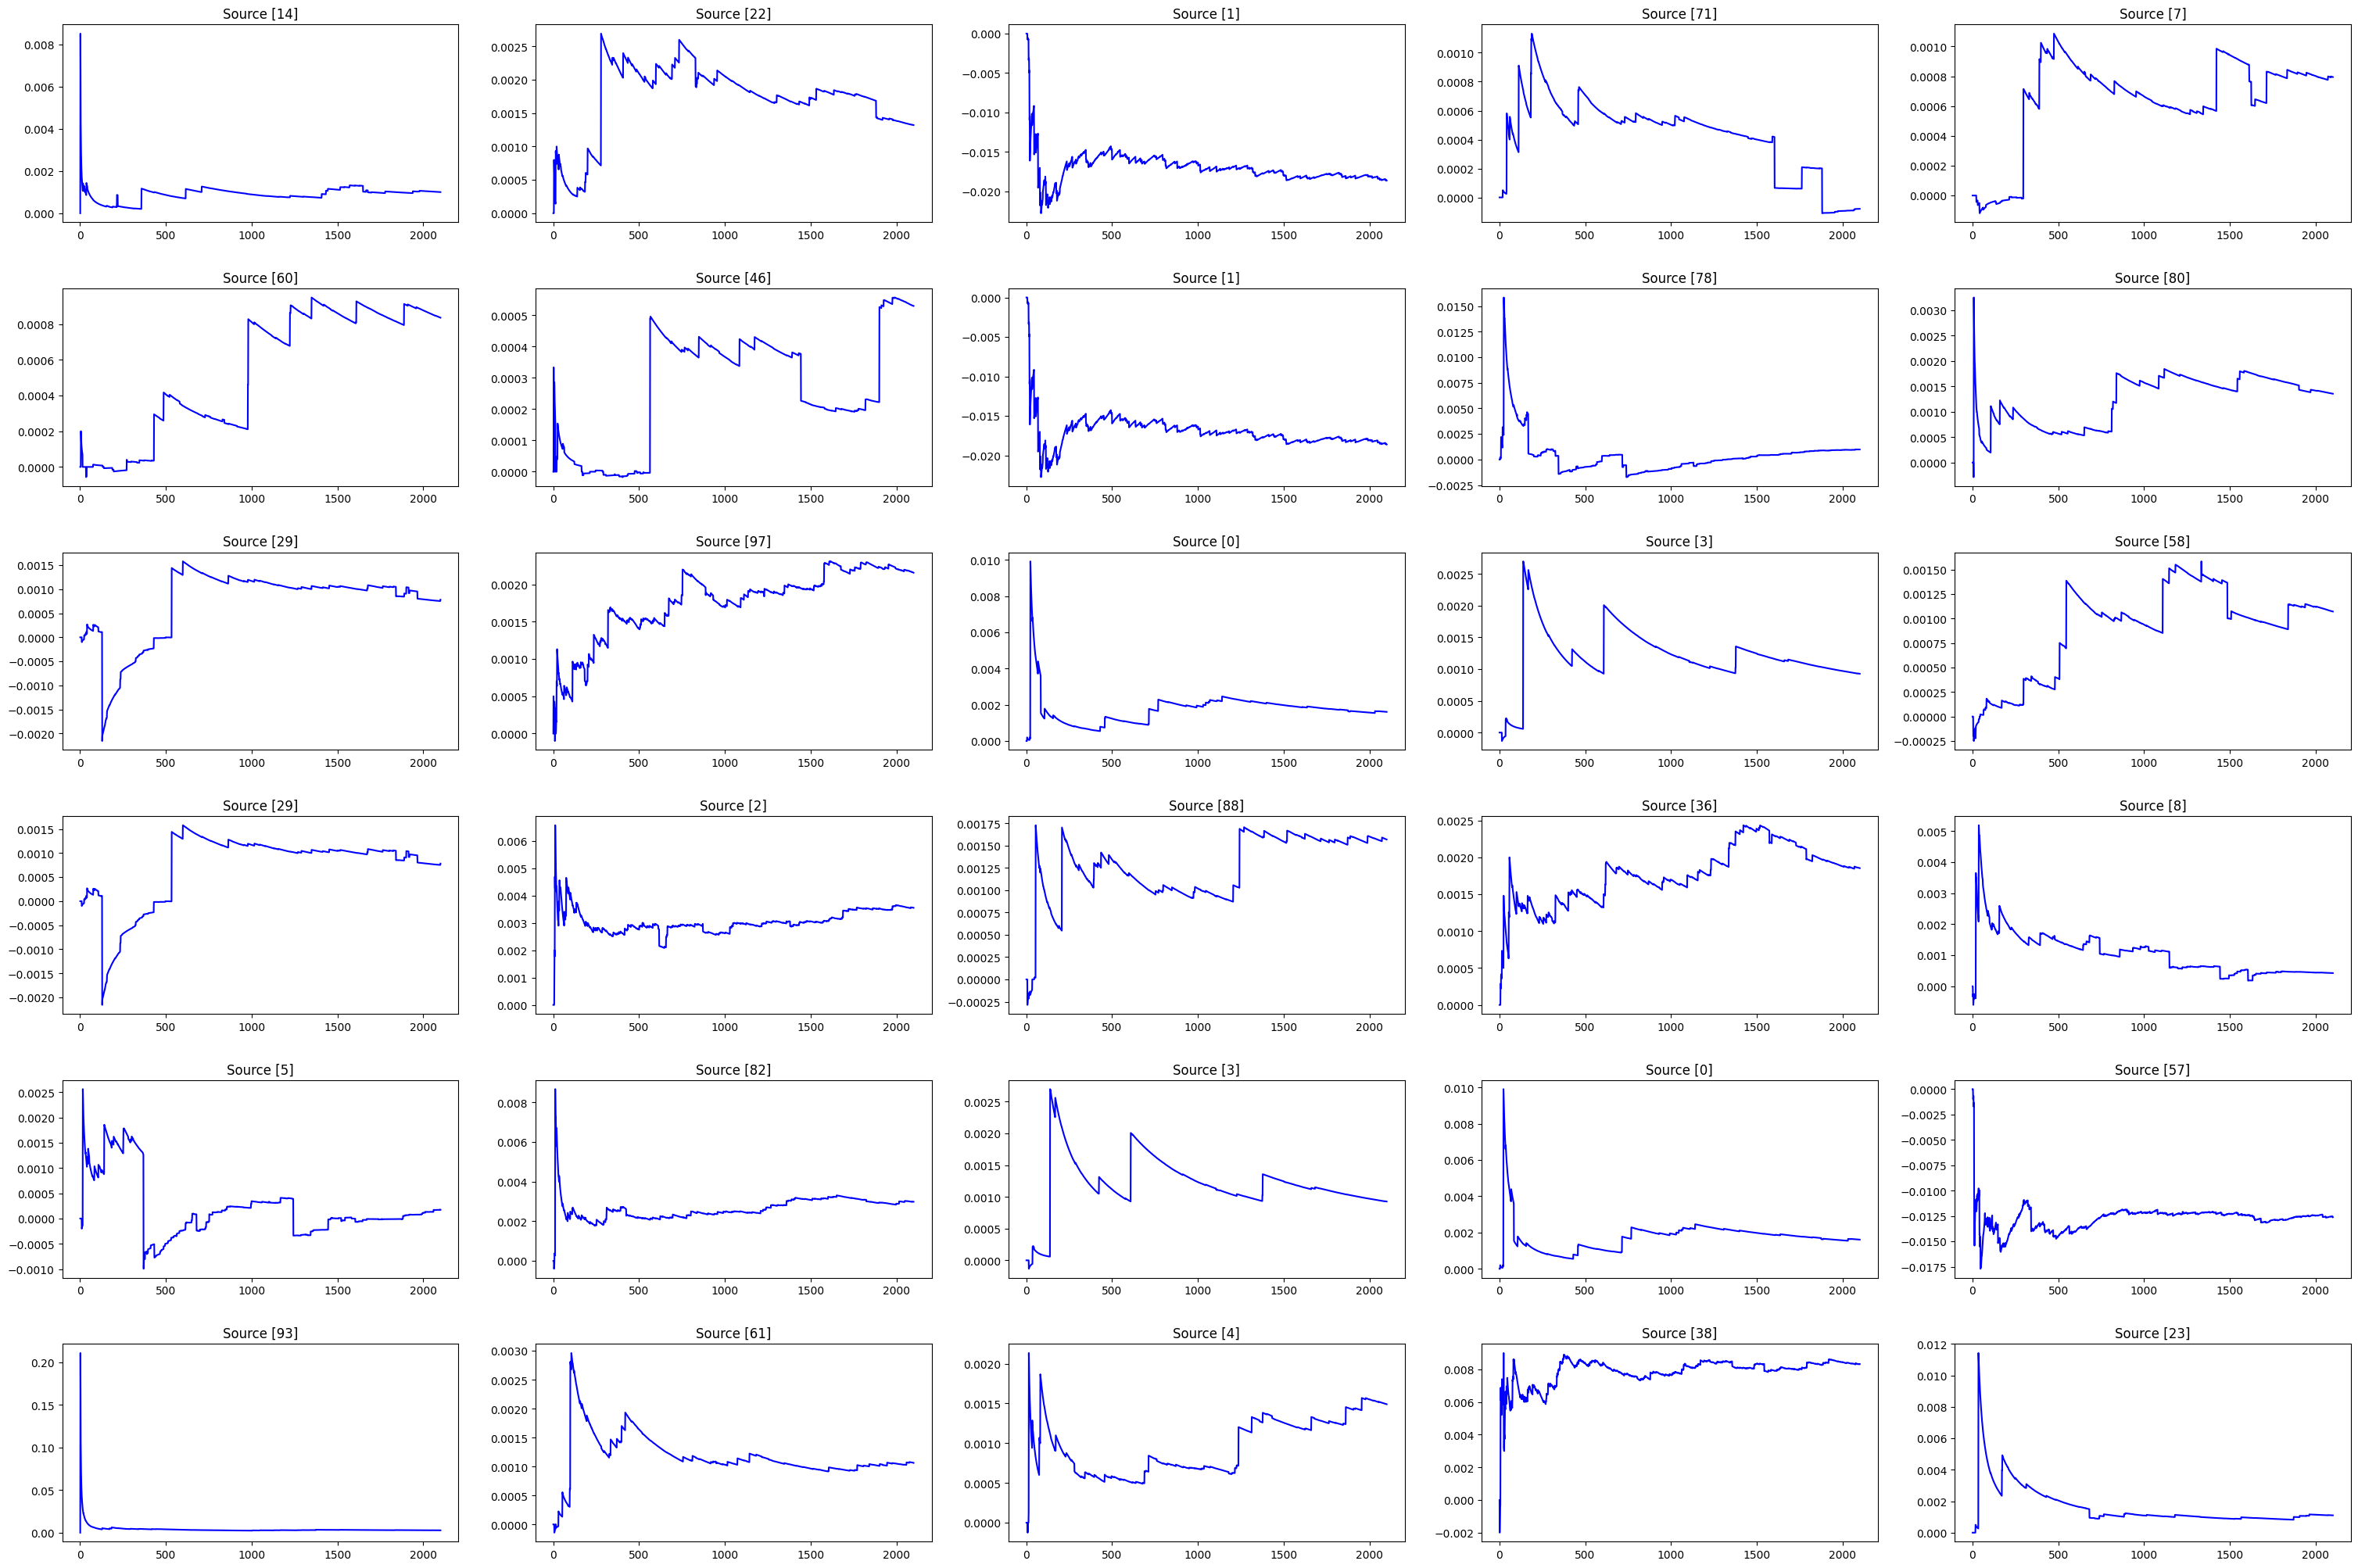

In [26]:
%matplotlib inline
dshap.convergence_plots(source_indexes=np.random.randint(low=0, high=train_size - 1, size=(30, 1)), figsize=(30, 20),
                        h_pad=4, w_pad=4, plot_more_than_25=True)

Let us remove $50\%$ of the top valued sources in the stroke dataset.

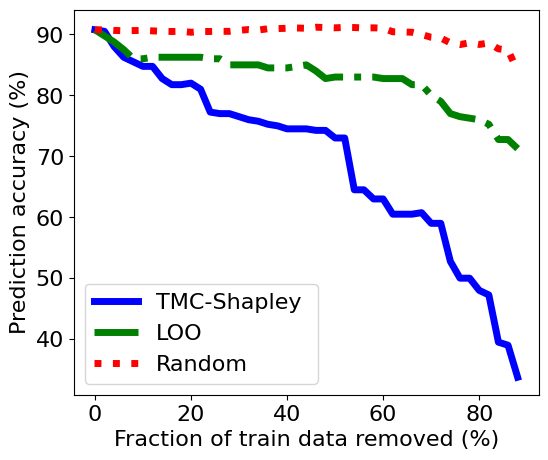

In [35]:
%matplotlib inline
dshap.performance_plots([dshap.vals_tmc, dshap.vals_loo], num_plot_markers=train_size // 2,
                        sources=None, figsize=(6, 5), fontsize=16)